# Módulo de testeo para NMF

A continuación se harán pruebas para el archivo "Test_1.wav", que contiene la grabación de una pieza cuyos instrumentos son un violín y un piano. La idea es separarlos de manera independiente.

In [1]:
import numpy as np
import os
import matplotlib.pyplot as plt
import soundfile as sf
import librosa
from sklearn.decomposition import NMF
from IPython.display import Audio
from scipy.signal.windows import tukey
#from math_functions import wiener_filter

# Ventana hamming

Se define la ventana hamming de manera matemática.

In [2]:
def hamming_window(N):
    # Definición de la ventana hamming de modo que se pueda generar para un
    # largo de ventana definido
    return np.asarray([0.53836 - 0.46164*np.cos((2*np.pi*i)/N)
                       for i in range(int(N))])

# Ventana hann

Se define la ventana hann de manera matemática.

In [3]:
def hann_window(N):
    # Definición de la ventana hamming de modo que se pueda generar para un
    # largo de ventana definido
    return np.asarray([0.5 - 0.5*np.cos((2*np.pi*i)/N)
                       for i in range(int(N))])

# Definición de algunas funciones previas

En primer lugar, se define la función que creará el espectrograma, en conjunto con la función de espectrograma inverso.

# Espectrograma

In [4]:
def get_spectrogram(audio, samplerate, N=512, padding=512, overlap=0, window='tukey'):
    # Lista donde se almacenará los valores del espectrograma
    spect = []
    # Lista de tiempo
    times = []
    
    # Variables auxiliares
    t = 0   # Tiempo
    
    # Seleccionar ventana
    if window == 'tukey':
        wind_mask = tukey(N)
    elif window == 'hamming':
        wind_mask = hamming_window(N)
    elif window == 'hann':
        wind_mask = hann_window(N) + 1e-5
    elif window is None:
        wind_mask = np.array([1] * N)
    
    # Iteración sobre el audio
    while audio.any():
        # Se corta la cantidad de muestras que se necesite, o bien, las que se
        # puedan cortar
        if len(audio) >= N:
            q_samples = N
            step = int(N * (1 - overlap))
        else:
            break
            # q_samples = step = len(audio)
            
        # Recorte en la cantidad de muestras
        audio_frame = audio[:q_samples]
        audio = audio[step:]
               
        # Ventaneando
        audio_frame_wind = audio_frame * wind_mask
        
        # Aplicando padding
        audio_padded = np.append(audio_frame_wind, [0] * padding)
        
        # Aplicando transformada de fourier
        audio_fft = np.fft.fft(audio_padded)
               
        # Agregando a los vectores del espectro
        spect.append(audio_fft)
        
        # Agregando al vector de tiempo
        times.append(t)
        t += step/samplerate
        
    # Generar el vector de frecuencias para cada ventana
    freqs = np.linspace(0, samplerate, N+padding)
        
    # Una vez obtenido el spect_mag y spect_pha, se pasa a matriz
    spect = np.array(spect, dtype=np.complex64)
    
    # Se retornan los valores que permiten construir el espectrograma correspondiente
    return times, freqs, spect.T

# Espectrograma inverso

In [67]:
def get_inverse_spectrogram(X, window='tukey', whole=False):
    # Preguntar si es que la señal está en el rango 0-samplerate. En caso de que no sea así,
    # se debe "espejar" para que se tenga el rango completo
    if not whole:
        X = np.concatenate((X, np.flip(X[1:, :], axis=0)))
    
    # Obtener la dimensión de la matriz
    rows, cols = X.shape
    print(X.shape)
    
    # Seleccionar ventana
    if window == 'tukey':
        wind_mask = tukey(rows)
    elif window == 'hamming':
        wind_mask = hamming_window(rows)
    elif window == 'hann':
        wind_mask = hann_window(rows)
    elif window is None:
        wind_mask = np.array([1] * rows)
    
    # Definición de una lista en la que se almacena la transformada inversa
    inv_spect = []
    
    # Transformando columna a columna (nótese la división en tiempo por una ventana definida)
    for i in range(cols):
        inv_spect += list(np.divide(np.fft.ifft(X[:, i]), wind_mask))
        
    return np.array(inv_spect)

# Trabajo con el audio

En primer lugar, se obtendrá el espectrograma para corroborar que la función implementada tiene la misma forma que el ejemplo de la página de MIR.

En primer lugar, se hace lectura del audio, y dado que viene en formato estéreo, se mezclan ambos para obtener la señal entre -1 y 1 con el objetivo de que no se sature el sonido.

# Test_1.wav

In [6]:
# Lectura del audio
audio, samplerate = sf.read('Test_1.wav')

# Normalizar audio para ambos canales
audio[:,0] = audio[:,0]/max(abs(audio[:,0])) 
audio[:,1] = audio[:,1]/max(abs(audio[:,1]))

# Mezclando ambos canales para obtener una señal monoaural
audio_mono = 0.5 * (audio[:,0] + audio[:,1])

# Escuchar
Audio(audio_mono, rate=samplerate)

# Drums.wav

In [69]:
# Lectura del audio
audio_mono, samplerate = sf.read('Drums.wav')

# Escuchar
Audio(audio_mono, rate=samplerate)

# Prueba de flips

In [70]:
a = np.array([[1,2,3],[4,5,6]])
a_flip = np.flip(a, axis=0)

b = np.concatenate((a, a_flip))
print(b)
print(b.shape)


[[1 2 3]
 [4 5 6]
 [4 5 6]
 [1 2 3]]
(4, 3)


# Prueba de valores de FFT

In [72]:
fft_test = np.fft.fft(audio_mono)
print(fft_test)

[-885.37460327  +0.j          182.5245712 +317.12677697j
  -94.46325328+146.47765687j ...  -15.6212056   -5.14087895j
  -94.46325328-146.47765687j  182.5245712 -317.12677697j]


<IPython.core.display.Javascript object>


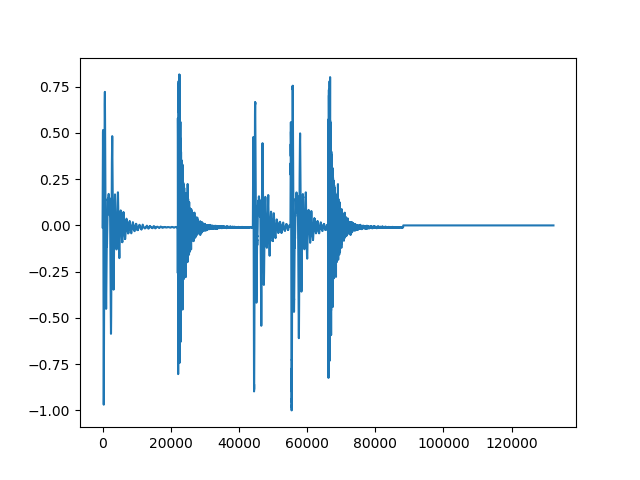

In [9]:
%matplotlib notebook
plt.plot(audio_mono)
plt.show()

# Definición de parámetros de trabajo

In [17]:
# Opciones del script
comps_list = [2] #range(10, 500, 20)
N = 2048     # Cantidad de muestras por cada frame

In [27]:
# Aplicando la función del espectrograma

# Obteniendo el espectrograma
t, f, S = get_spectrogram(audio_mono, samplerate, N=N, padding=0, overlap=0, window='hamming')

# Guardar valores de la dimensión del espectrograma
row_dim, col_dim = S.shape

# Definiendo la magnitud
X = np.abs(S)

print('Dimensiones')
print(S.shape)
print(S[0:int(row_dim/2), :].shape)

Dimensiones
(2048, 44)
(1024, 44)


<IPython.core.display.Javascript object>


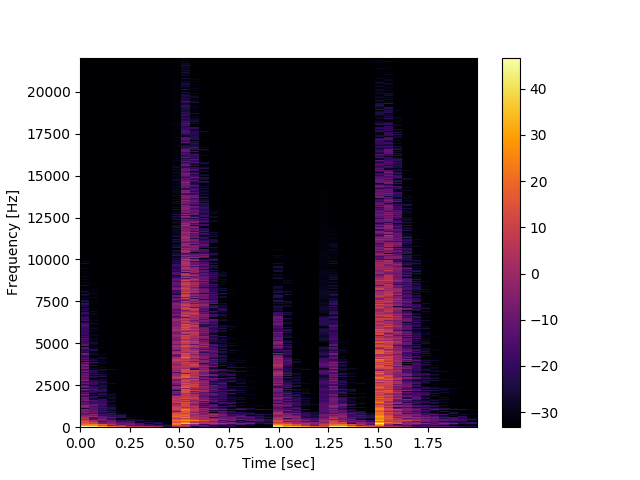

In [28]:
%matplotlib notebook
plt.pcolormesh(t, f[0:row_dim//2], librosa.amplitude_to_db(X[0:int(row_dim/2)]), cmap='inferno')
plt.colorbar()
plt.ylabel('Frequency [Hz]')
plt.xlabel('Time [sec]')
plt.show()

<IPython.core.display.Javascript object>


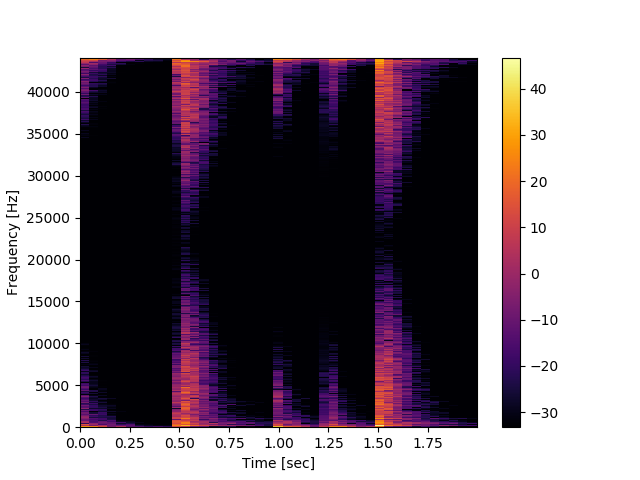

In [38]:
%matplotlib notebook
X_mid = X[0:row_dim//2]
final = np.concatenate((X_mid, np.flip(X_mid, axis=0)))
plt.pcolormesh(t, f, librosa.amplitude_to_db(final), cmap='inferno')
plt.colorbar()
plt.ylabel('Frequency [Hz]')
plt.xlabel('Time [sec]')
plt.show()

<IPython.core.display.Javascript object>


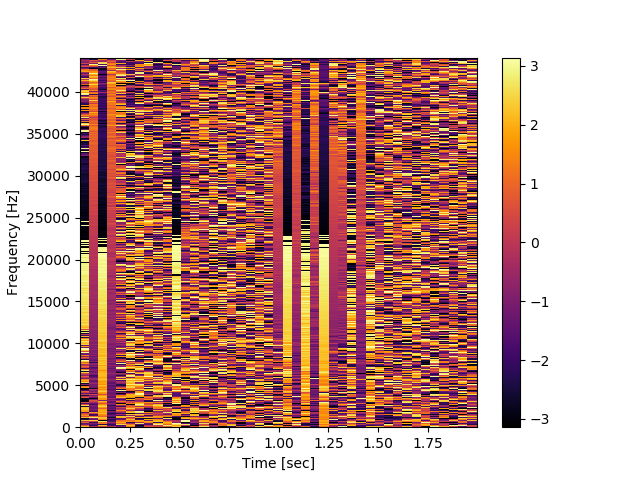

In [73]:
%matplotlib notebook
plt.pcolormesh(t, f, np.angle(S), cmap='inferno')
plt.colorbar()
plt.ylabel('Frequency [Hz]')
plt.xlabel('Time [sec]')
plt.show()

# Probando la transformada de Fourier inversa para cada frame

(2047, 44)


<IPython.core.display.Javascript object>


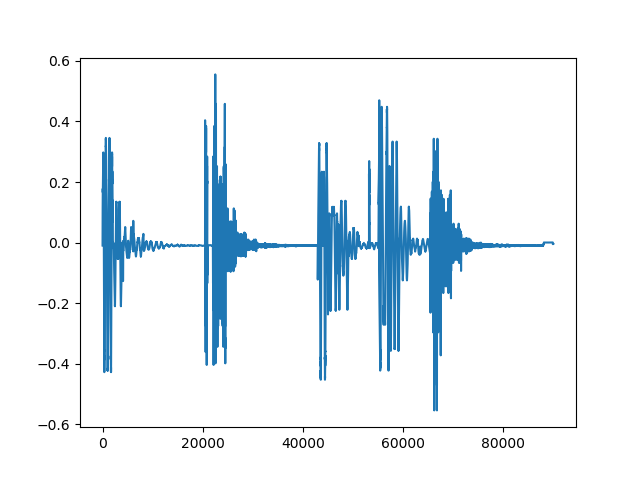

In [68]:
%matplotlib notebook
S_test = S[0:row_dim//2, :]
test_inv = get_inverse_spectrogram(np.abs(S_test) * np.exp(1j * np.angle(S_test)), window='hamming', whole=False)
plt.plot(test_inv)
plt.show()

In [60]:
Audio(test_inv, rate=samplerate)

# Aplicando NMF

In [175]:
model = NMF(n_components=2, beta_loss='itakura-saito', solver='mu')
# Utilizando el valor absoluto
X = abs(S)
print(X.shape)
W = model.fit_transform(X)
print(W.shape)

(2048, 44)
(2048, 2)


Obteniendo los patrones del espectrograma mediante la matriz $W$.

<IPython.core.display.Javascript object>


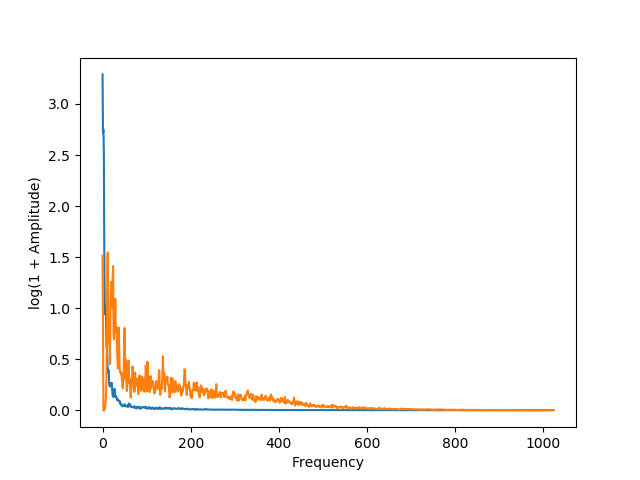

In [176]:
%matplotlib notebook
logW = np.log1p(W)                         # Para realzar más la forma de las componentes (solo visualización)
f = np.arange(W.shape[0]/2)
plt.plot(f, logW[0:int(logW.shape[0]/2),0], f, logW[0:int(logW.shape[0]/2),1])
plt.xlabel('Frequency')
plt.ylabel('log(1 + Amplitude)')
plt.show()

Mostrando las activaciones temporales dadas por la matriz $H$.

(2, 44)


<IPython.core.display.Javascript object>


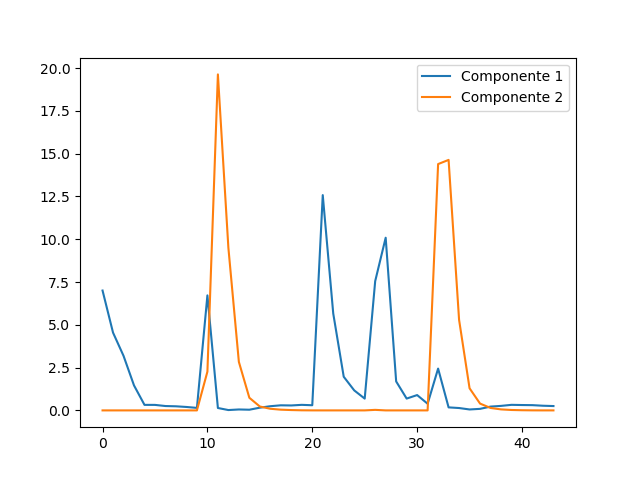

In [177]:
%matplotlib notebook
H = model.components_
print(H.shape)
t = np.arange(H.shape[1])
plt.plot(t, H[0], t, H[1])
plt.legend(('Componente 1', 'Componente 2'))
plt.show()

Finalmente recuperando la señal original a partir de estos componentes...

# Forma 1: Sin máscara

In [178]:
Y0 = np.outer(W[:,0], H[0]) * np.exp(1j * np.angle(S))
Y1 = np.outer(W[:,1], H[1]) * np.exp(1j * np.angle(S))
Y0.shape, Y1.shape

((2048, 44), (2048, 44))

# Forma 2: Con máscara (filtro de Wiener)

In [179]:
# Por implementar

# Aplicando transformada inversa de Fourier a cada frame (STFT)

In [182]:
y0 = get_inverse_spectrogram(Y0, window='hamming')
y1 = get_inverse_spectrogram(Y1, window='hamming')
y0.shape, y1.shape

((90112,), (90112,))

# Escuchando los audios...

In [183]:
Audio(y0, rate=samplerate)

c:\users\chris\appdata\local\programs\python\python36\lib\site-packages\IPython\lib\display.py:158: ComplexWarning: Casting complex values to real discards the imaginary part
  data = np.array(data, dtype=float)


In [184]:
Audio(y1, rate=samplerate)